# **HW2 Q Section B - Using pretrained net - VGG16**

In [113]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Loading the images in colab is a bit wierd. after runing this section you need
# to choose the desired images located in your local machine
from google.colab import files
from IPython.display import Image

from scipy.ndimage.filters import gaussian_filter

from sklearn.decomposition import PCA
import os
from scipy.spatial import distance

print(tf.__version__)

def normalize(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
  
def reshape_im(x):
  x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
  return x


def normalize_image(image):
  image_R = normalize(image[:, :, 0])
  image_G = normalize(image[:, :, 1])
  image_B = normalize(image[:, :, 2])
  image_plot = np.dstack((image_R, image_G, image_B))
  return image_plot

def show_activations(model, image, layer_name, title):
  activations = get_activations(model, image)
  print(activations.keys())
  res = activations[layer_name]
  print(res.shape)
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(res)[:,:,0])
  plt.title('{} response {} channel 0'.format(title, layer_name))
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(res)[:,:,20])
  plt.title('{} response {} channel 20'.format(title, layer_name))
  
def find_min_dist_im(all_cats_features, all_dogs_features, im_features):
  dst_to_cats = np.zeros([1, 10])
  dst_to_dogs = np.zeros([1, 10])
  idx = 0
  for row in zip(all_cats_features, all_dogs_features):
    dst_to_cats[0, idx] = distance.euclidean(im_features, row[0])
    dst_to_dogs[0, idx] = distance.euclidean(im_features, row[1])
    idx += 1
  min_cat_idx, min_cat = dst_to_cats.argmin(), dst_to_cats.min()
  min_dog_idx, min_dog = dst_to_dogs.argmin(), dst_to_dogs.min() 
  if min_cat < min_dog:
    name = 'cat_' + str(min_cat_idx) + '.jpg'
  else:
    name = 'dog_' + str(min_dog_idx) + '.jpg'
  return name

1.13.1


In [114]:
pip install keract

In [0]:
# Import the VGG16 CNN from keras and some helper librarys
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras import layers
from keract import get_activations

In [116]:
# Section 1 - Load the pretrained VGG 16

# for the sake of easy visualisation we here print the model shape
model = VGG16()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [117]:
# Section 2 -  Load the bird images


#please import your local  'bird_0.jpg' and 'bird_1.jpg'
uploaded = files.upload()

bird_0.jpg  cat_5.jpg  dog_2.jpg  dog_9.jpg		    Tiger_3.jpg
bird_1.jpg  cat_6.jpg  dog_3.jpg  myCat.jpg		    Tiger_4.jpg
cat_0.jpg   cat_7.jpg  dog_4.jpg  myDog.jpg		    Tiger.jpg
cat_1.jpg   cat_8.jpg  dog_5.jpg  resident_owls_bogart.jpg  Wolf_1.jpg
cat_2.jpg   cat_9.jpg  dog_6.jpg  sample_data		    Wolf.jpg
cat_3.jpg   dog_0.jpg  dog_7.jpg  Tiger_1.jpg
cat_4.jpg   dog_1.jpg  dog_8.jpg  Tiger_2.jpg


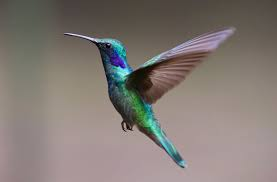

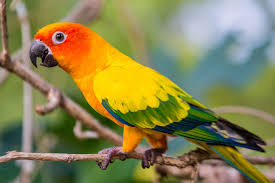

In [119]:
# Plot original images
!ls
display(Image(filename = 'bird_0.jpg'))
display(Image(filename = 'bird_1.jpg'))

original bird_0 shape: (1, 224, 224, 3) , data type: <class 'numpy.ndarray'> and dyn rage of 255.0
original bird_1 shape: (1, 224, 224, 3) , data type: <class 'numpy.ndarray'> and dyn rage of 255.0
bird_0 predicted as: hummingbird (97.59%)
bird_1 predicted as: lorikeet (88.85%)


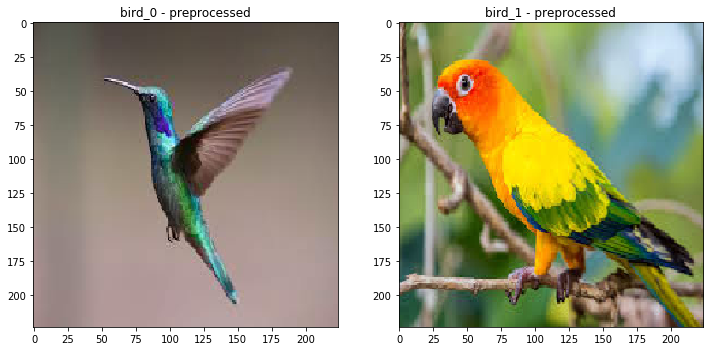

In [122]:
# Section 2


bird_0 = load_img('bird_0.jpg', target_size=(224, 224))
bird_1 = load_img('bird_1.jpg', target_size=(224, 224))

# convert the image pixels to a numpy array
bird_0 = img_to_array(bird_0)
bird_1 = img_to_array(bird_1)

# reshape data for the model
bird_0 = reshape_im(bird_0)
bird_1 = reshape_im(bird_1)

print('original bird_0 shape: {} , data type: {} and dyn rage of {}'.format(bird_0.shape, type(bird_0), (bird_0.max() - bird_0.min())))
print('original bird_1 shape: {} , data type: {} and dyn rage of {}'.format(bird_1.shape, type(bird_1), (bird_1.max() - bird_1.min())))

# prepare the image for the VGG model this method only substract the RGB mean
# of the training set according to the original paper:
# "The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel."
#  - Very Deep Convolutional Networks for Large-Scale Image Recognition, 2014.
bird_0 = preprocess_input(bird_0)
bird_1 = preprocess_input(bird_1)

# for ploting purposes we normalize the image by substruct its mean and devide by the dyn range.
bird_0_R = normalize(bird_0[-1, :, :, 0])
bird_0_G = normalize(bird_0[-1, :, :, 1])
bird_0_B = normalize(bird_0[-1, :, :, 2])

bird_1_R = normalize(bird_1[-1, :, :, 0])
bird_1_G = normalize(bird_1[-1, :, :, 1])
bird_1_B = normalize(bird_1[-1, :, :, 2])

bird_0_plot = np.dstack((bird_0_B, bird_0_G, bird_0_R))
bird_1_plot = np.dstack((bird_1_B, bird_1_G, bird_1_R))

# Plot the preprocessed images
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(bird_0_plot)
plt.title('bird_0 - preprocessed')
plt.subplot(1,2,2)
plt.imshow(bird_1_plot)
plt.show
plt.title('bird_1 - preprocessed')


# feed forward the images for the net

# predict the probability across all output classes
yhat_0 = model.predict(bird_0)
yhat_1 = model.predict(bird_1)
# convert the probabilities to class labels
label_0 = decode_predictions(yhat_0)
label_1 = decode_predictions(yhat_1)

# retrieve the most likely result, e.g. highest probability
label_0 = label_0[0][0]
label_1 = label_1[0][0]

# print the classification
print('bird_0 predicted as: %s (%.2f%%)' % (label_0[1], label_0[2]*100))
print('bird_1 predicted as: %s (%.2f%%)' % (label_1[1], label_1[2]*100))

bird_0.jpg  cat_5.jpg  dog_2.jpg  dog_9.jpg		    Tiger_3.jpg
bird_1.jpg  cat_6.jpg  dog_3.jpg  myCat.jpg		    Tiger_4.jpg
cat_0.jpg   cat_7.jpg  dog_4.jpg  myDog.jpg		    Tiger.jpg
cat_1.jpg   cat_8.jpg  dog_5.jpg  resident_owls_bogart.jpg  Wolf_1.jpg
cat_2.jpg   cat_9.jpg  dog_6.jpg  sample_data		    Wolf.jpg
cat_3.jpg   dog_0.jpg  dog_7.jpg  Tiger_1.jpg
cat_4.jpg   dog_1.jpg  dog_8.jpg  Tiger_2.jpg


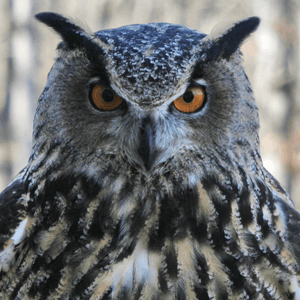

In [123]:
# Section - 3
# please import your local 'resident_owls_bogart.jpg'
uploaded = files.upload()
!ls
display(Image(filename = 'resident_owls_bogart.jpg'))

In [124]:
# Section - 3

# preprocess the image and use it as input to the net
RAW_DATA_resident_owls_bogart = load_img('resident_owls_bogart.jpg', target_size=(224, 224))

# convert the image pixels to a numpy array
RAW_DATA_resident_owls_bogart = img_to_array(RAW_DATA_resident_owls_bogart)

# reshape data for the model
resident_owls_bogart = reshape_im(RAW_DATA_resident_owls_bogart)
resident_owls_bogart = preprocess_input(resident_owls_bogart)
# predict the probability across all output classes
yhat_owl = model.predict(resident_owls_bogart)

# convert the probabilities to class labels
lable_owl = decode_predictions(yhat_owl)

# retrieve the most likely result, e.g. highest probability
lable_owl = lable_owl[0][0]

# print the classification
print('resident_owls_bogart image predicted as: %s (%.2f%%)' % (lable_owl[1], lable_owl[2]*100))

resident_owls_bogart image predicted as: great_grey_owl (99.89%)


Text(0.5, 1.0, 'Owl - gauss filtered with sigma = 3')

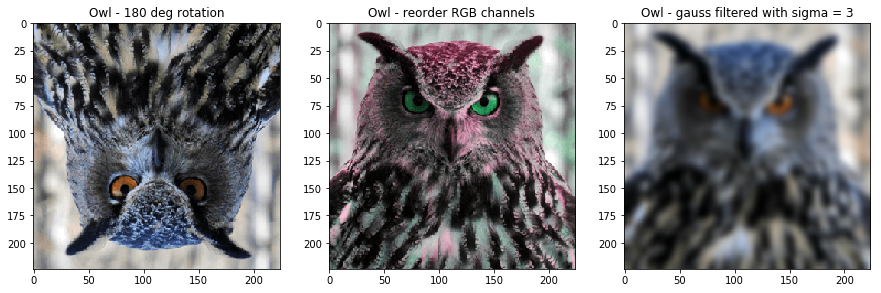

In [125]:
# Section - 4


# Geometric transform - Rotate 180 degrees
resident_owls_bogart_GEO = np.rot90(RAW_DATA_resident_owls_bogart, 2)

# Color transform - replace the RGB channels order
resident_owls_bogart_R = RAW_DATA_resident_owls_bogart[:, :, 0]
resident_owls_bogart_G = RAW_DATA_resident_owls_bogart[:, :, 1]
resident_owls_bogart_B = RAW_DATA_resident_owls_bogart[:, :, 2]
resident_owls_bogart_COLOR = np.dstack((resident_owls_bogart_B, resident_owls_bogart_R, resident_owls_bogart_G))

# Filtering the image - gauss filter the image
sigma = 3
resident_owls_bogart_FILT_R = gaussian_filter(RAW_DATA_resident_owls_bogart[:, :, 0], sigma=sigma)
resident_owls_bogart_FILT_G = gaussian_filter(RAW_DATA_resident_owls_bogart[:, :, 1], sigma=sigma)
resident_owls_bogart_FILT_B = gaussian_filter(RAW_DATA_resident_owls_bogart[:, :, 2], sigma=sigma)
resident_owls_bogart_FILT = np.dstack((resident_owls_bogart_FILT_R, resident_owls_bogart_FILT_G, resident_owls_bogart_FILT_B))


# noise = np.random.normal(0, 1, RAW_DATA_resident_owls_bogart.shape)
# resident_owls_bogart_FILT = RAW_DATA_resident_owls_bogart + noise
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(normalize_image(resident_owls_bogart_GEO))
plt.title('Owl - 180 deg rotation')
plt.subplot(1,3,2)
plt.imshow(normalize_image(resident_owls_bogart_COLOR))
plt.title('Owl - reorder RGB channels')
plt.subplot(1,3,3)
plt.imshow(normalize_image(resident_owls_bogart_FILT))
plt.title('Owl - gauss filtered with sigma = {}'.format(sigma))

In [126]:
# Section - 4

# Preprocess the images and feed them to the cnn
# reshape data for the model
resident_owls_bogart_GEO = reshape_im(resident_owls_bogart_GEO)
resident_owls_bogart_COLOR = reshape_im(resident_owls_bogart_COLOR)
resident_owls_bogart_FILT = reshape_im(resident_owls_bogart_FILT)

# preprocess
resident_owls_bogart_GEO = preprocess_input(resident_owls_bogart_GEO)
resident_owls_bogart_COLOR = preprocess_input(resident_owls_bogart_COLOR)
resident_owls_bogart_FILT = preprocess_input(resident_owls_bogart_FILT)

# Predict the probability across all output classes
yhat_GEO = model.predict(resident_owls_bogart_GEO)
yhat_COLOR = model.predict(resident_owls_bogart_COLOR)
yhat_FILT = model.predict(resident_owls_bogart_FILT)

# convert the probabilities to class labels
lable_GEO = decode_predictions(yhat_GEO)
lable_COLOR = decode_predictions(yhat_COLOR)
lable_FILT = decode_predictions(yhat_FILT)

# retrieve the most likely result, e.g. highest probability
lable_GEO = lable_GEO[0][0]
lable_COLOR = lable_COLOR[0][0]
lable_FILT = lable_FILT[0][0]

# print the classification
print('Geometric transformed prediction: %s (%.2f%%)' % (lable_GEO[1], lable_GEO[2]*100))
print('Colored transformed prediction: %s (%.2f%%)' % (lable_COLOR[1], lable_COLOR[2]*100))
print('Filtered prediction: %s (%.2f%%)' % (lable_FILT[1], lable_FILT[2]*100))

Geometric transformed prediction: great_grey_owl (100.00%)
Colored transformed prediction: great_grey_owl (98.00%)
Filtered prediction: Kerry_blue_terrier (33.13%)


(3, 3, 3, 64)
block1_conv1_2/Relu:0
dict_keys(['input_3:0', 'block1_conv1_2/Relu:0', 'block1_conv2_2/Relu:0', 'block1_pool_2/MaxPool:0', 'block2_conv1_2/Relu:0', 'block2_conv2_2/Relu:0', 'block2_pool_2/MaxPool:0', 'block3_conv1_2/Relu:0', 'block3_conv2_2/Relu:0', 'block3_conv3_2/Relu:0', 'block3_pool_2/MaxPool:0', 'block4_conv1_2/Relu:0', 'block4_conv2_2/Relu:0', 'block4_conv3_2/Relu:0', 'block4_pool_2/MaxPool:0', 'block5_conv1_2/Relu:0', 'block5_conv2_2/Relu:0', 'block5_conv3_2/Relu:0', 'block5_pool_2/MaxPool:0', 'flatten_2/Reshape:0', 'fc1_2/Relu:0', 'fc2_2/Relu:0', 'predictions_2/Softmax:0'])
(1, 224, 224, 64)
dict_keys(['input_3:0', 'block1_conv1_2/Relu:0', 'block1_conv2_2/Relu:0', 'block1_pool_2/MaxPool:0', 'block2_conv1_2/Relu:0', 'block2_conv2_2/Relu:0', 'block2_pool_2/MaxPool:0', 'block3_conv1_2/Relu:0', 'block3_conv2_2/Relu:0', 'block3_conv3_2/Relu:0', 'block3_pool_2/MaxPool:0', 'block4_conv1_2/Relu:0', 'block4_conv2_2/Relu:0', 'block4_conv3_2/Relu:0', 'block4_pool_2/MaxPool:0

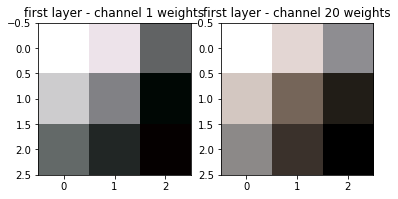

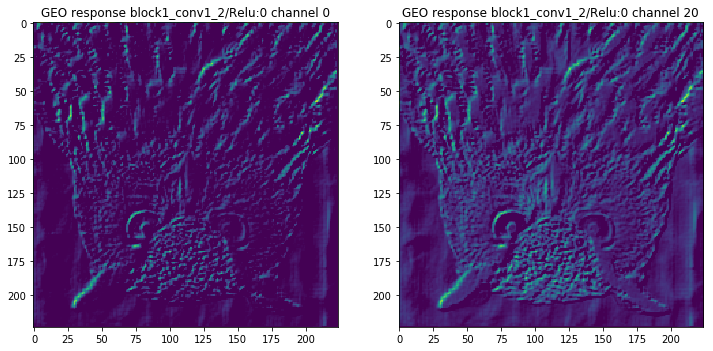

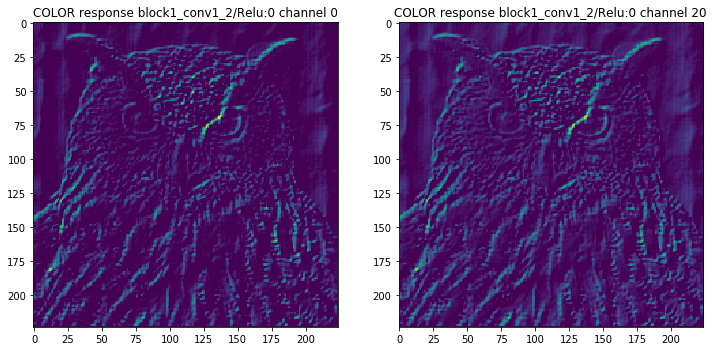

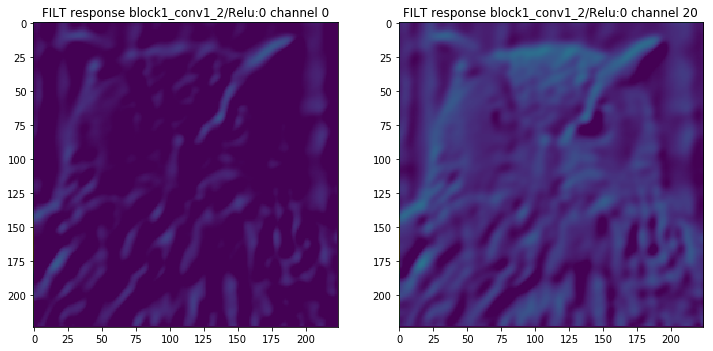

In [141]:
# Section - 5

# Visualise the filters
conv_1 = model.get_layer('block1_conv1')
weights_1 = conv_1.get_weights()
print(weights_1[0].shape)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(normalize_image(weights_1[0][:, :, :, 0]))
plt.title('first layer - channel 1 weights')
plt.subplot(1,2,2)
plt.imshow(normalize_image(weights_1[0][:, :, :, 20]))
plt.title('first layer - channel 20 weights')

activations = get_activations(model, resident_owls_bogart_GEO)

# layer_name ='block1_conv1_1/Relu:0'
layer_name = list(activations.keys())[1]
print(layer_name)
show_activations(model, resident_owls_bogart_GEO, layer_name, 'GEO')
show_activations(model, resident_owls_bogart_COLOR, layer_name, 'COLOR')
show_activations(model, resident_owls_bogart_FILT, layer_name, 'FILT')

In [23]:
# Section - 6

#load the images
uploaded = files.upload() #please uploaad all the dogs images
uploaded = files.upload() #please uploaad all the cats images
!ls

Saving dog_0.jpg to dog_0.jpg
Saving dog_1.jpg to dog_1.jpg
Saving dog_2.jpg to dog_2.jpg
Saving dog_3.jpg to dog_3.jpg
Saving dog_4.jpg to dog_4.jpg
Saving dog_5.jpg to dog_5.jpg
Saving dog_6.jpg to dog_6.jpg
Saving dog_7.jpg to dog_7.jpg
Saving dog_8.jpg to dog_8.jpg
Saving dog_9.jpg to dog_9.jpg


Saving cat_0.jpg to cat_0.jpg
Saving cat_1.jpg to cat_1.jpg
Saving cat_2.jpg to cat_2.jpg
Saving cat_3.jpg to cat_3.jpg
Saving cat_4.jpg to cat_4.jpg
Saving cat_5.jpg to cat_5.jpg
Saving cat_6.jpg to cat_6.jpg
Saving cat_7.jpg to cat_7.jpg
Saving cat_8.jpg to cat_8.jpg
Saving cat_9.jpg to cat_9.jpg
bird_0.jpg  cat_3.jpg  cat_8.jpg  dog_3.jpg  dog_8.jpg
bird_1.jpg  cat_4.jpg  cat_9.jpg  dog_4.jpg  dog_9.jpg
cat_0.jpg   cat_5.jpg  dog_0.jpg  dog_5.jpg  resident_owls_bogart.jpg
cat_1.jpg   cat_6.jpg  dog_1.jpg  dog_6.jpg  sample_data
cat_2.jpg   cat_7.jpg  dog_2.jpg  dog_7.jpg


In [142]:
!ls

bird_0.jpg  cat_5.jpg  dog_2.jpg  dog_9.jpg		    Tiger_3.jpg
bird_1.jpg  cat_6.jpg  dog_3.jpg  myCat.jpg		    Tiger_4.jpg
cat_0.jpg   cat_7.jpg  dog_4.jpg  myDog.jpg		    Tiger.jpg
cat_1.jpg   cat_8.jpg  dog_5.jpg  resident_owls_bogart.jpg  Wolf_1.jpg
cat_2.jpg   cat_9.jpg  dog_6.jpg  sample_data		    Wolf.jpg
cat_3.jpg   dog_0.jpg  dog_7.jpg  Tiger_1.jpg
cat_4.jpg   dog_1.jpg  dog_8.jpg  Tiger_2.jpg


fc2_2/Relu:0
shape of the projected data is: (20, 2)


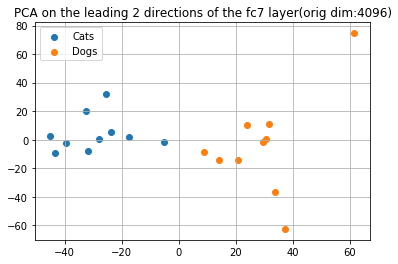

In [143]:
# Section - 6 



pca = PCA(n_components=2)
fc7_cats_features = np.zeros([10, 4096])
fc7_dogs_features = np.zeros([10, 4096])

fc7 = model.get_layer('fc2')
# layer_name = 'fc2_1/Relu:0'
layer_name = list(activations.keys())[-2]
print(layer_name)
idx_cat = 0
idx_dog = 0

for pic_name in os.listdir('/content'):
    if not pic_name.endswith('.jpg'):
      continue
    raw_im = load_img(pic_name, target_size=(224, 224))
    raw_im = img_to_array(raw_im)
    im = reshape_im(raw_im)
    im = preprocess_input(im)
    activations = get_activations(model, im)
    fc7 = activations[layer_name]
    if pic_name[:3] == 'cat':
      fc7_cats_features[idx_cat, :] = np.squeeze(fc7)
      idx_cat += 1
    if pic_name[:3] == 'dog':
      fc7_dogs_features[idx_dog, :] = np.squeeze(fc7)
      idx_dog += 1

# Preform PCA
fc7_all_features = np.concatenate([fc7_cats_features, fc7_dogs_features])

pca_transformed = pca.fit_transform(fc7_all_features)
print('shape of the projected data is: {}'.format(pca_transformed.shape))
plt.scatter(pca_transformed[:10, 0], pca_transformed[:10, 1], label='Cats')
plt.scatter(pca_transformed[10:, 0], pca_transformed[10:, 1], label='Dogs')
plt.title('PCA on the leading 2 directions of the fc7 layer(orig dim:4096)')
plt.grid()
plt.legend()

In [90]:
# Section - 7

#load the images
uploaded = files.upload() # please upload the 'myCat' image and the 'myDog' image
!ls


bird_0.jpg  cat_4.jpg  dog_0.jpg  dog_6.jpg  resident_owls_bogart.jpg
bird_1.jpg  cat_5.jpg  dog_1.jpg  dog_7.jpg  sample_data
cat_0.jpg   cat_6.jpg  dog_2.jpg  dog_8.jpg
cat_1.jpg   cat_7.jpg  dog_3.jpg  dog_9.jpg
cat_2.jpg   cat_8.jpg  dog_4.jpg  myCat.jpg
cat_3.jpg   cat_9.jpg  dog_5.jpg  myDog.jpg


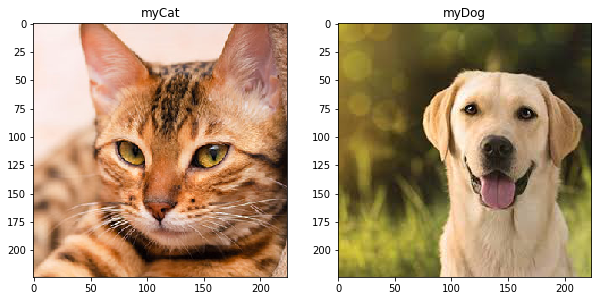

In [144]:
# Section - 7

RAW_DATA_myCat = load_img('myCat.jpg', target_size=(224, 224))
RAW_DATA_myDog = load_img('myDog.jpg', target_size=(224, 224))

# convert the image pixels to a numpy array
RAW_DATA_myCat = img_to_array(RAW_DATA_myCat)
RAW_DATA_myDog = img_to_array(RAW_DATA_myDog)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normalize_image(RAW_DATA_myCat))
plt.title('myCat')
plt.subplot(1,2,2)
plt.imshow(normalize_image(RAW_DATA_myDog))
plt.title('myDog')

# reshape data for the model
myCat = reshape_im(RAW_DATA_myCat)
myDog = reshape_im(RAW_DATA_myDog)

myCat = preprocess_input(myCat)
myDog = preprocess_input(myDog)



fc2_2/Relu:0


Text(0.5, 1.0, "Nearset image to 'myDog'")

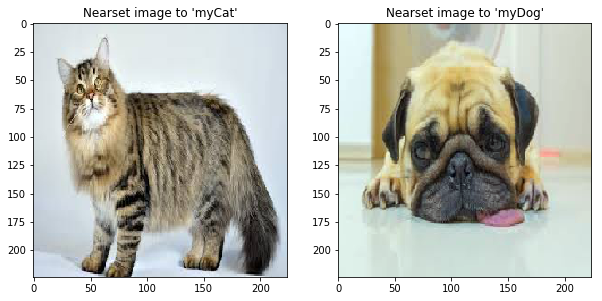

In [146]:
# Section - 7

#extract the fc7 features
# layer_name = 'fc2_1/Relu:0'
layer_name = list(activations.keys())[-2]
print(layer_name)
activations = get_activations(model, myCat)
fc7_cat = activations[layer_name]
    
activations = get_activations(model, myDog)
fc7_dog = activations[layer_name]


closest_to_myCat_animal_name = find_min_dist_im(fc7_cats_features, fc7_dogs_features, fc7_cat)
closest_to_myDog_animal_name = find_min_dist_im(fc7_cats_features, fc7_dogs_features, fc7_dog)

RAW_DATA_nearest_myCat = load_img(closest_to_myCat_animal_name, target_size=(224, 224))
RAW_DATA_nearest_myDog = load_img(closest_to_myDog_animal_name, target_size=(224, 224))

# convert the image pixels to a numpy array
RAW_DATA_nearest_myCat = img_to_array(RAW_DATA_nearest_myCat)
RAW_DATA_nearest_myDog = img_to_array(RAW_DATA_nearest_myDog)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normalize_image(RAW_DATA_nearest_myCat))
plt.title('Nearset image to \'myCat\'')
plt.subplot(1,2,2)
plt.imshow(normalize_image(RAW_DATA_nearest_myDog))
plt.title('Nearset image to \'myDog\'')
    
    
    

In [111]:
# Section - 8

# upload the images of the tiger and the wolf please
uploaded = files.upload() # please upload the 'Tiger_4' image and the 'Wolf_1' image
!ls

Saving Tiger_4.jpg to Tiger_4.jpg
bird_0.jpg  cat_5.jpg  dog_2.jpg  dog_9.jpg		    Tiger_3.jpg
bird_1.jpg  cat_6.jpg  dog_3.jpg  myCat.jpg		    Tiger_4.jpg
cat_0.jpg   cat_7.jpg  dog_4.jpg  myDog.jpg		    Tiger.jpg
cat_1.jpg   cat_8.jpg  dog_5.jpg  resident_owls_bogart.jpg  Wolf_1.jpg
cat_2.jpg   cat_9.jpg  dog_6.jpg  sample_data		    Wolf.jpg
cat_3.jpg   dog_0.jpg  dog_7.jpg  Tiger_1.jpg
cat_4.jpg   dog_1.jpg  dog_8.jpg  Tiger_2.jpg


fc2_2/Relu:0


Text(0.5, 1.0, "Nearset image to 'Wolf'")

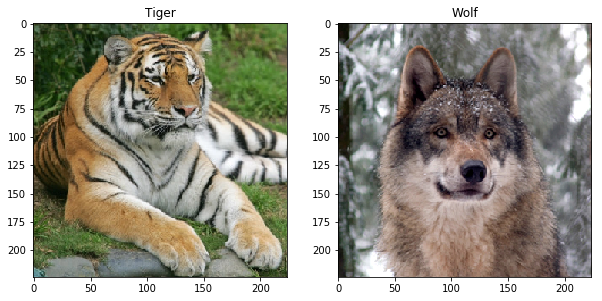

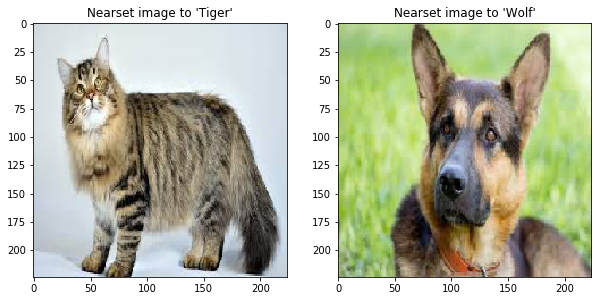

In [148]:
# Section - 8
# repeat section 7

RAW_DATA_Tiger = load_img('Tiger_4.jpg', target_size=(224, 224))
RAW_DATA_Wolf = load_img('Wolf_1.jpg', target_size=(224, 224))

# convert the image pixels to a numpy array
RAW_DATA_Tiger = img_to_array(RAW_DATA_Tiger)
RAW_DATA_Wolf = img_to_array(RAW_DATA_Wolf)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normalize_image(RAW_DATA_Tiger))
plt.title('Tiger')
plt.subplot(1,2,2)
plt.imshow(normalize_image(RAW_DATA_Wolf))
plt.title('Wolf')

# reshape data for the model
Tiger = reshape_im(RAW_DATA_Tiger)
Wolf = reshape_im(RAW_DATA_Wolf)

Tiger = preprocess_input(Tiger)
Wolf = preprocess_input(Wolf)

#extract the fc7 features
# layer_name = 'fc2_1/Relu:0'
layer_name = list(activations.keys())[-2]
print(layer_name)
activations = get_activations(model, Tiger)
fc7_Tiger = activations[layer_name]
    
activations = get_activations(model, Wolf)
fc7_Wolf = activations[layer_name]


closest_to_Tiger_animal_name = find_min_dist_im(fc7_cats_features, fc7_dogs_features, fc7_Tiger)
closest_to_Wolf_animal_name = find_min_dist_im(fc7_cats_features, fc7_dogs_features, fc7_Wolf)

RAW_DATA_nearest_Tiger = load_img(closest_to_Tiger_animal_name, target_size=(224, 224))
RAW_DATA_nearest_Wolf = load_img(closest_to_Wolf_animal_name, target_size=(224, 224))

# convert the image pixels to a numpy array
RAW_DATA_nearest_Tiger = img_to_array(RAW_DATA_nearest_Tiger)
RAW_DATA_nearest_Wolf = img_to_array(RAW_DATA_nearest_Wolf)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normalize_image(RAW_DATA_nearest_Tiger))
plt.title('Nearset image to \'Tiger\'')
plt.subplot(1,2,2)
plt.imshow(normalize_image(RAW_DATA_nearest_Wolf))
plt.title('Nearset image to \'Wolf\'')